In [ ]:
pip install imbalanced-learn

     ------------------------------------ 238.4/238.4 kB 239.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%ls

decisiontree_model.pkl  mlp_model.h5            rf_model.pkl   train/              val_features.npy
dt_model.pkl            pca_model.pkl           svm_model.pkl  train_features.npy  val_labels.npy
knn_model.pkl           randomforest_model.pkl  test/          train_labels.npy


In [8]:
%cd

/content/drive/MyDrive/Alzheimers Detection


In [10]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import backend as K
from sklearn.neural_network import MLPClassifier

In [14]:
def build_alexnet():
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(256, (5, 5), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(1000, activation='relu')
    ])
    return model


In [11]:
data_dir = r"./"  # Set your dataset path
categories = ['Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final AD JPEG']
img_size = 224
X, y = [], []

def load_images_from_folder(folder, label):
    path = os.path.join(data_dir, folder)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(label)

In [12]:
for label, category in enumerate(categories):
    load_images_from_folder(os.path.join('train', category), label)
    load_images_from_folder(os.path.join('test', category), label)

In [13]:
X = np.array(X) / 255.0  # Normalize images
y = np.array(y)

In [15]:
ros = RandomOverSampler()
X, y = ros.fit_resample(X.reshape(X.shape[0], -1), y)
X = X.reshape(-1, img_size, img_size, 3)

In [16]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

In [17]:
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model_alex = build_alexnet()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
def extract_hypercolumn(image):
    vgg_features = base_model_vgg.predict(image)
    alex_features = base_model_alex.predict(image)
    vgg_flatten = vgg_features.flatten()
    alex_flatten = alex_features.flatten()
    return np.concatenate([vgg_flatten, alex_flatten])


In [19]:
X_features = np.array([extract_hypercolumn(img.reshape(1, img_size, img_size, 3)) for img in X])

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

In [21]:
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(100, activation='relu')(input_layer)
encoded = Dense(50, activation='relu')(encoded)
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32, verbose=1)
X_autoencoded = autoencoder.predict(X_scaled)


Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.7664
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.6507
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6165
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5947
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5877
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5880
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5781
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5523
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5561
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5844
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5660
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5610
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5866
Epoch 14/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5637
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5511
Epoch 16/20
91/91 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create dictionary of models based on the note image
models = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'ANN': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'NB': GaussianNB(),
    'LR': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Ensemble': AdaBoostClassifier(random_state=42)
}


In [23]:
results = {}

# Function to evaluate and plot ROC curve
def evaluate_and_plot_roc(models, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(12, 10))

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Metrics Calculation
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        f1 = f1_score(y_test, y_test_pred, average='weighted')

        # For multiclass ROC, we need to binarize the output
        # We'll use one-vs-rest approach
        y_test_bin = tf.keras.utils.to_categorical(y_test)

        # Get probabilities for ROC curve
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:  # For models without predict_proba
            decision_function = getattr(model, "decision_function", None)
            if decision_function:
                y_score = model.decision_function(X_test)
            else:
                # Some models may not have predict_proba or decision_function
                # Skip ROC for these models
                print(f"{name} doesn't support probability predictions, skipping ROC")
                continue

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # For multiclass, calculate ROC for each class
        if len(np.unique(y_test)) > 2:  # If multiclass
            n_classes = len(np.unique(y_test))
            for i in range(n_classes):
                try:
                    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
                except:
                    continue

            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

            # Plot ROC curve
            plt.plot(fpr["micro"], tpr["micro"],
                     label=f'{name} (AUC = {roc_auc["micro"]:.2f})',
                     linewidth=2)
        else:  # If binary
            fpr[0], tpr[0], _ = roc_curve(y_test, y_score[:, 1])
            roc_auc[0] = auc(fpr[0], tpr[0])
            plt.plot(fpr[0], tpr[0],
                     label=f'{name} (AUC = {roc_auc[0]:.2f})',
                     linewidth=2)

        # Store results
        results[name] = {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': roc_auc["micro"] if len(np.unique(y_test)) > 2 else roc_auc[0]
        }

        # Print results
        print(f'{name} - Training Accuracy: {train_acc:.2f}, Validation Accuracy: {test_acc:.2f}')
        print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}')

    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_auc_curve.png')
    plt.show()

    # Create comparison table
    comparison_df = pd.DataFrame(results).T
    comparison_df = comparison_df[['train_acc', 'test_acc', 'precision', 'recall', 'f1_score', 'auc']]
    comparison_df.columns = ['Training Accuracy', 'Validation Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
    print("\nModel Comparison:")
    print(comparison_df)

    return comparison_df


Training RF...
RF - Training Accuracy: 1.00, Validation Accuracy: 0.91
Precision: 0.93, Recall: 0.91, F1-score: 0.92
Training SVM...
SVM - Training Accuracy: 0.83, Validation Accuracy: 0.75
Precision: 0.77, Recall: 0.75, F1-score: 0.75
Training DT...
DT - Training Accuracy: 1.00, Validation Accuracy: 0.83
Precision: 0.81, Recall: 0.83, F1-score: 0.81
Training KNN...
KNN - Training Accuracy: 0.83, Validation Accuracy: 0.70
Precision: 0.71, Recall: 0.70, F1-score: 0.70
Training ANN...
ANN - Training Accuracy: 1.00, Validation Accuracy: 0.86
Precision: 0.86, Recall: 0.86, F1-score: 0.86
Training NB...
NB - Training Accuracy: 0.36, Validation Accuracy: 0.32
Precision: 0.40, Recall: 0.32, F1-score: 0.29
Training LR...
LR - Training Accuracy: 0.64, Validation Accuracy: 0.58
Precision: 0.58, Recall: 0.58, F1-score: 0.58
Training XGBoost...
XGBoost - Training Accuracy: 1.00, Validation Accuracy: 0.90
Precision: 0.91, Recall: 0.90, F1-score: 0.90
Training Ensemble...
Ensemble - Training Accurac

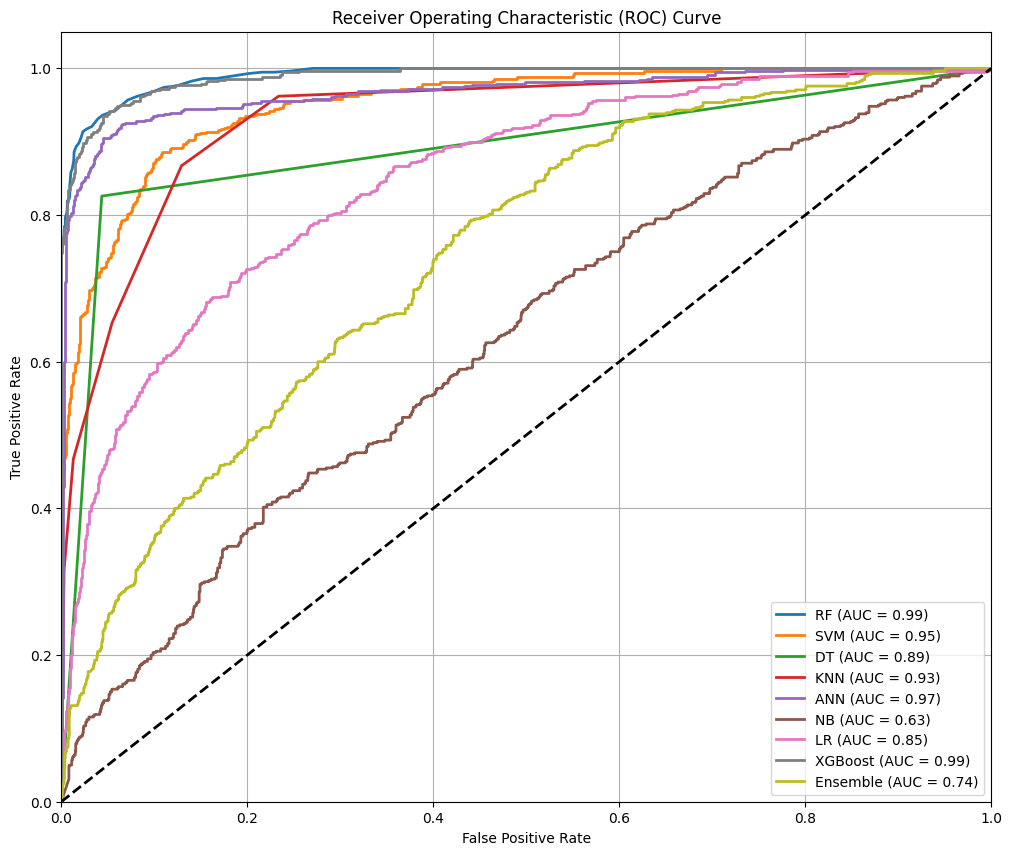


Model Comparison:
          Training Accuracy  Validation Accuracy  Precision    Recall  \
RF                 1.000000             0.913793   0.925282  0.913793   
SVM                0.833621             0.748276   0.766321  0.748276   
DT                 1.000000             0.825862   0.813509  0.825862   
KNN                0.833190             0.703448   0.705513  0.703448   
ANN                1.000000             0.863793   0.859705  0.863793   
NB                 0.359052             0.320690   0.403769  0.320690   
LR                 0.643103             0.582759   0.575828  0.582759   
XGBoost            1.000000             0.903448   0.907089  0.903448   
Ensemble           0.428448             0.446552   0.475964  0.446552   

          F1-score       AUC  
RF        0.916180  0.990334  
SVM       0.752170  0.951645  
DT        0.814889  0.891164  
KNN       0.703274  0.931735  
ANN       0.859791  0.967260  
NB        0.286793  0.625203  
LR        0.575178  0.848216  
XG

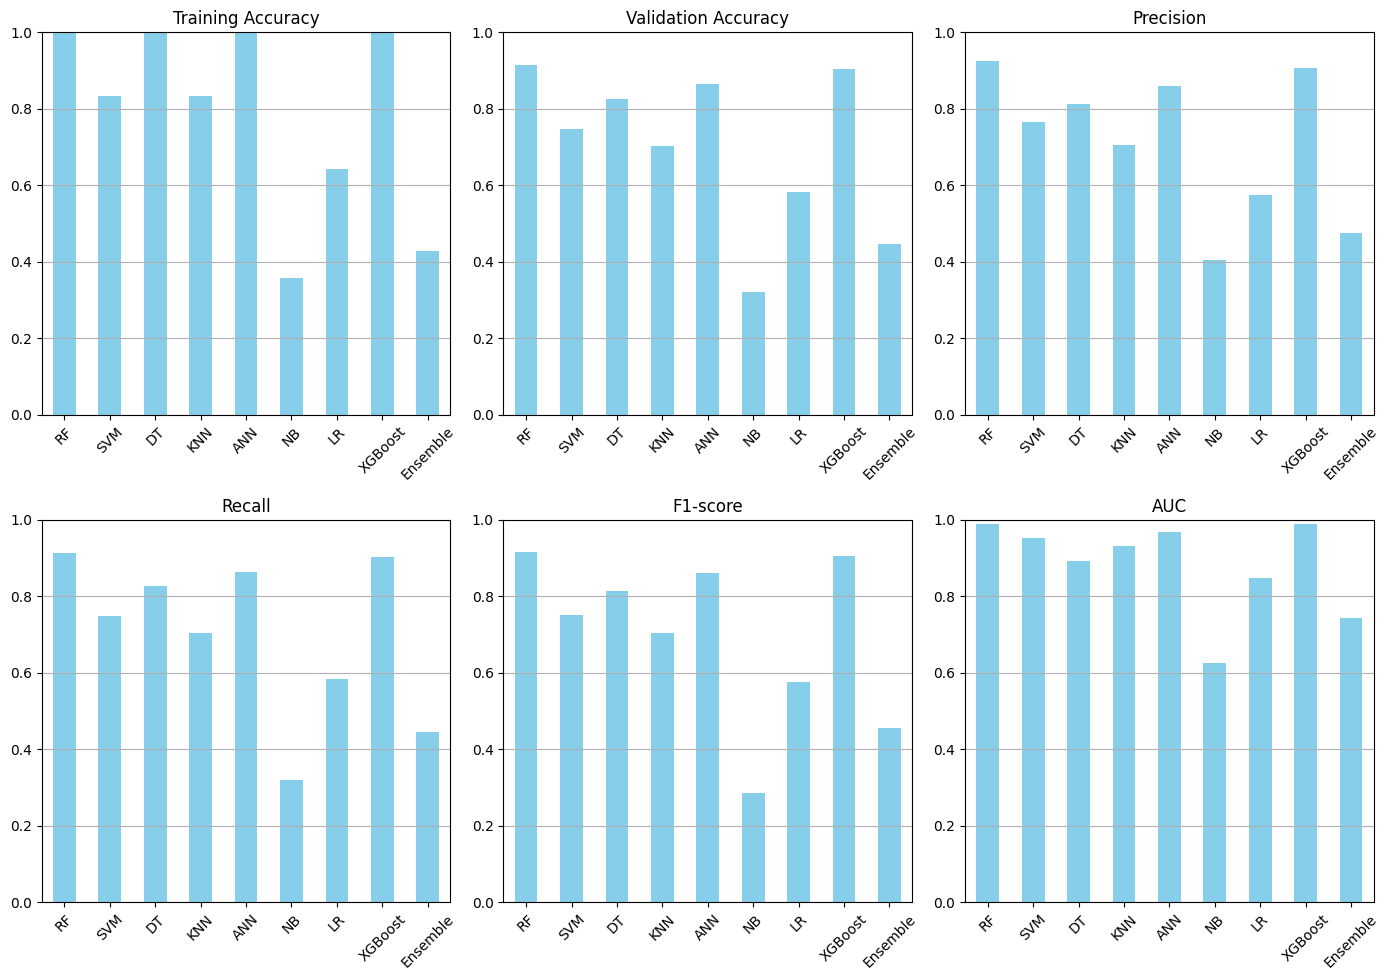

In [24]:
import pandas as pd

# Evaluate models and plot ROC curves
model_comparison = evaluate_and_plot_roc(models, X_train, X_test, y_train, y_test)

# Save the comparison table to CSV
model_comparison.to_csv('model_comparison.csv')

# Plot metrics comparison
metrics = ['Training Accuracy', 'Validation Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    model_comparison[metric].plot(kind='bar', color='skyblue')
    plt.title(metric)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.grid(axis='y')

plt.show()
